# GODAS
https://catalog.pangeo.io/browse/master/ocean/GODAS/

https://www.psl.noaa.gov//data/gridded/data.godas.html

In [7]:
from dask_gateway import GatewayCluster

cluster = GatewayCluster()
cluster.scale(10)
#cluster.adapt(minimum=2, maximum=10)  # or cluster.scale(n) to a fixed size.
client = cluster.get_client()

In [8]:
client

Client Scheduler: gateway://traefik-gcp-uscentral1b-prod-dask-gateway.prod:80/prod.7668b6ae941f4450a1a80be6f4c8e4a8 Dashboard: /services/dask-gateway/clusters/prod.7668b6ae941f4450a1a80be6f4c8e4a8/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [18]:
client.close()
cluster.close()

In [1]:
import xarray as xr
from matplotlib import pyplot as plt
import gcsfs
import dask
import dask.array as dsa
import numpy as np
import fsspec
%matplotlib inline

In [2]:
xr.set_options(display_style='text')

In [3]:
fs = gcsfs.GCSFileSystem(requester_pays=True)
mapping = fs.get_mapper('gs://pangeo-ncep-godas')
ds = xr.open_zarr(mapping, consolidated=True)

In [4]:
coords = ds.coords.to_dataset().reset_coords()
ds = ds.reset_coords(drop=True)

In [5]:
coords_roll = coords.roll(lon=500, lon_u=500)
ds_roll = ds.roll(lon=500, lon_u=500)

<ipython-input-5-ed45c25d685c>:1: FutureWarning: roll_coords will be set to False in the future. Explicitly set roll_coords to silence warning.
  coords_roll = coords.roll(lon=500, lon_u=500)
<ipython-input-5-ed45c25d685c>:2: FutureWarning: roll_coords will be set to False in the future. Explicitly set roll_coords to silence warning.
  ds_roll = ds.roll(lon=500, lon_u=500)


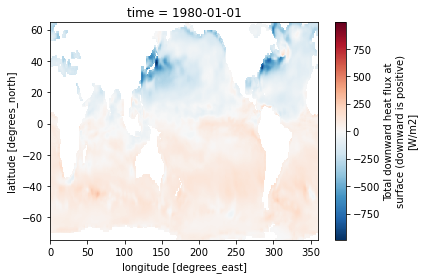

In [8]:
ds.thflx[0].plot()

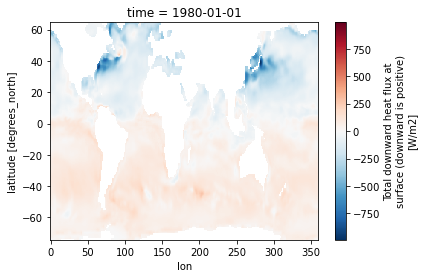

In [7]:
ds_roll.thflx[0].drop('lon').plot()

In [69]:
ds_roll.lon.isel(lon=170)

<xarray.DataArray 'lon' ()>
array(30.5, dtype=float32)
Coordinates:
    lon      float32 30.5
Attributes:
    GridType:       Cylindrical Equidistant Projection Grid
    actual_range:   [0.5, 359.5]
    axis:           X
    long_name:      longitude
    standard_name:  longitude
    units:          degrees_east

In [22]:
ds_roll.lon_u.isel(lon_u=74)

<xarray.DataArray 'lon_u' ()>
array(295., dtype=float32)
Coordinates:
    lon_u    float32 295.0
Attributes:
    GridType:       Cylindrical Equidistant Projection Grid
    actual_range:   [1.0, 360.0]
    axis:           X
    long_name:      longitude
    standard_name:  longitude
    units:          degrees_east

In [6]:
#WG boundaries (80˚S, 62˚S, 65˚W, 30˚E)
lower_lat = 0 #-74.16667
upper_lat = 37 #-61.83
left_lon =  75 #295.5
right_lon = 170 #30.5

lower_lat_u = 0 #-74.0
upper_lat_u = 36 #-62.0
left_lon_u = 74 #295.0
right_lon_u = 169 #30.0

In [7]:
#set the boundaries
lat_range = dict(lat=slice(lower_lat, upper_lat), lat_u=slice(lower_lat_u, upper_lat_u))
lon_range = dict(lon=slice(left_lon, right_lon), lon_u=slice(left_lon_u, right_lon_u))

lat_range_no_face = dict(lat=slice(lower_lat, upper_lat))
lon_range_no_face = dict(lon=slice(left_lon, right_lon))

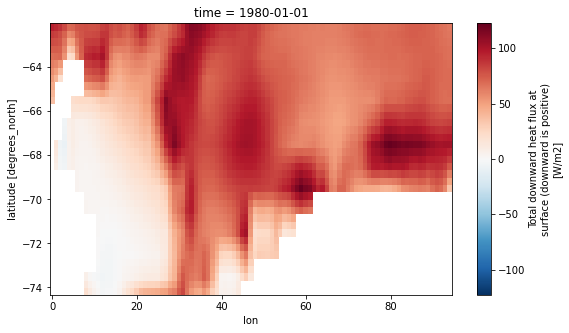

In [8]:
ds_roll.thflx[0].isel(**lat_range_no_face, **lon_range_no_face).drop('lon').plot(figsize=(9,5))

In [9]:
ds_wg = ds_roll.isel(**lat_range, **lon_range)
coords_wg = coords_roll.isel(**lat_range, **lon_range)

#### What can we compute with GODAS ds?
- [ ] surf flux
- [ ] sw flux
- [ ] lin_fs_correction
- [x] adv flux
- [ ] diff flux
- [ ] total tendency

## <font color='Green'>\begin{equation*} Surface\ Flux \end{equation*}</font>

In [45]:
#calculating meters per latitudinal & longitudinal degree
earth_radius = 6.371e6
earth_circumference = 2*np.pi*earth_radius
meters_per_degree = earth_circumference / 360
meters_per_degree

111194.92664455873

In [63]:
delta_lon = coords_wg.lon.diff('lon')

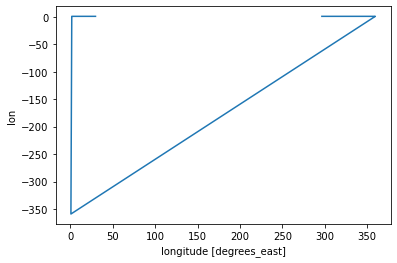

In [64]:
delta_lon.plot()

In [71]:
delta_lon

<xarray.DataArray 'lon' (lon: 94)>
array([   1.,    1.,    1.,    1.,    1.,    1.,    1.,    1.,    1.,
          1.,    1.,    1.,    1.,    1.,    1.,    1.,    1.,    1.,
          1.,    1.,    1.,    1.,    1.,    1.,    1.,    1.,    1.,
          1.,    1.,    1.,    1.,    1.,    1.,    1.,    1.,    1.,
          1.,    1.,    1.,    1.,    1.,    1.,    1.,    1.,    1.,
          1.,    1.,    1.,    1.,    1.,    1.,    1.,    1.,    1.,
          1.,    1.,    1.,    1.,    1.,    1.,    1.,    1.,    1.,
          1., -359.,    1.,    1.,    1.,    1.,    1.,    1.,    1.,
          1.,    1.,    1.,    1.,    1.,    1.,    1.,    1.,    1.,
          1.,    1.,    1.,    1.,    1.,    1.,    1.,    1.,    1.,
          1.,    1.,    1.,    1.], dtype=float32)
Coordinates:
  * lon      (lon) float32 296.5 297.5 298.5 299.5 300.5 ... 26.5 27.5 28.5 29.5

In [70]:
delta_lon.isel(lon=64)

<xarray.DataArray 'lon' ()>
array(-359., dtype=float32)
Coordinates:
    lon      float32 0.5

In [73]:
coords_wg.lon#.isel(lon=64)

<xarray.DataArray 'lon' (lon: 95)>
array([295.5, 296.5, 297.5, 298.5, 299.5, 300.5, 301.5, 302.5, 303.5, 304.5,
       305.5, 306.5, 307.5, 308.5, 309.5, 310.5, 311.5, 312.5, 313.5, 314.5,
       315.5, 316.5, 317.5, 318.5, 319.5, 320.5, 321.5, 322.5, 323.5, 324.5,
       325.5, 326.5, 327.5, 328.5, 329.5, 330.5, 331.5, 332.5, 333.5, 334.5,
       335.5, 336.5, 337.5, 338.5, 339.5, 340.5, 341.5, 342.5, 343.5, 344.5,
       345.5, 346.5, 347.5, 348.5, 349.5, 350.5, 351.5, 352.5, 353.5, 354.5,
       355.5, 356.5, 357.5, 358.5, 359.5,   0.5,   1.5,   2.5,   3.5,   4.5,
         5.5,   6.5,   7.5,   8.5,   9.5,  10.5,  11.5,  12.5,  13.5,  14.5,
        15.5,  16.5,  17.5,  18.5,  19.5,  20.5,  21.5,  22.5,  23.5,  24.5,
        25.5,  26.5,  27.5,  28.5,  29.5], dtype=float32)
Coordinates:
  * lon      (lon) float32 295.5 296.5 297.5 298.5 299.5 ... 26.5 27.5 28.5 29.5
Attributes:
    GridType:       Cylindrical Equidistant Projection Grid
    actual_range:   [0.5, 359.5]
    axis:           X
    long_name:      longitude
    standard_name:  longitude
    units:          degrees_east

In [48]:
#converting degrees lat to lat [meters]
delta_lat = coords_wg.lat.diff('lat')
lat = delta_lat * meters_per_degree

#converting degrees lon to lon [meters] (pinching at the poles)
delta_lon = 1
lon = coords_wg.lon * meters_per_degree * np.cos(np.deg2rad(coords_wg.lat))

In [49]:
heat_capacity_cp = 3.994e3 #J/kg/˚C
runit2mass = 1.035e3 #rho

surf_flux_th = ds_wg.thflx * lat * lon / (heat_capacity_cp * runit2mass)

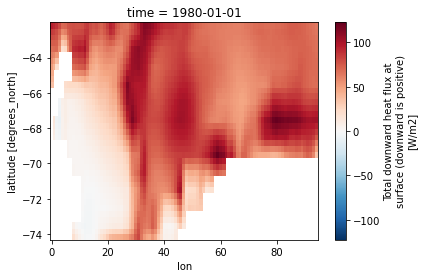

In [29]:
ds_wg.thflx[0].drop('lon').plot()

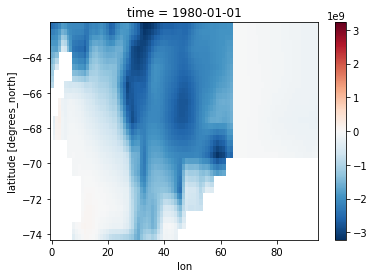

In [51]:
surf_flux_th[0].drop('lon').plot()

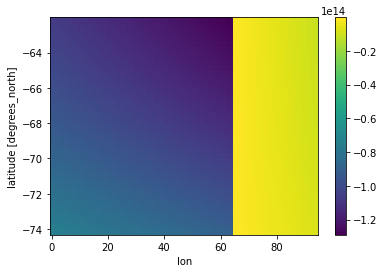

In [50]:
(lat * lon).drop('lon').plot()

## <font color='Green'>\begin{equation*} \Psi_{vel} \end{equation*}</font>

In [23]:
u_transport_right = (ds_wg.ucur * coords_wg.lat_u * coords_wg.lon_u * coords_wg.level).isel(lon_u=-1)
u_transport_left = (ds_wg.ucur * coords_wg.lat_u * coords_wg.lon_u * coords_wg.level).isel(lon_u=0)

v_transport = (ds_wg.vcur * coords_wg.lat_u * coords_wg.lon_u * coords_wg.level).isel(lat_u=-1)

Text(0.5, 1.0, 'V transport')

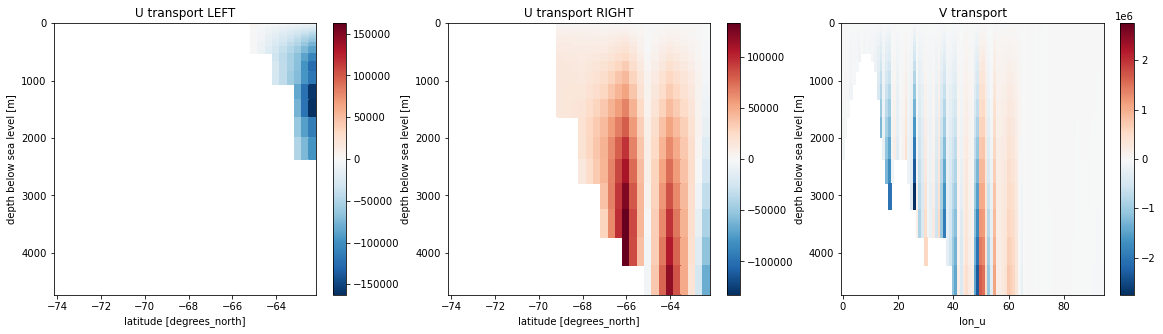

In [46]:
fig, (ax0,ax1,ax2) = plt.subplots(1,3, figsize=(20,5))

u_transport_left[0].plot(yincrease=False, ax=ax0)
ax0.set_title('U transport LEFT')
u_transport_right[0].plot(yincrease=False, ax=ax1) 
ax1.set_title('U transport RIGHT')
v_transport[0].drop('lon_u').plot(yincrease=False, ax=ax2)
ax2.set_title('V transport');

## <font color='Green'>\begin{equation*} Total\ Tendency \end{equation*}</font>